In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [81]:
plt.style.available
plt.style.use('fast')

<h1>Исходные данные и их описание</h1>
<h3>Основная задачи - предсказать цену дома в зависимости от различного рода признаков, представленных в имеющемся датасете</h3>
<h3>Ссылка на датасет:</h3>
<a href="url">https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data</a>

In [82]:
# read the dataset csv file
df = pd.read_csv("housing_price_dataset.csv")
print(df.shape)
df.head()

(50000, 6)


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [83]:
# check null values
print(df.isna().any())
print() 
print(df.isna().sum())

SquareFeet      False
Bedrooms        False
Bathrooms       False
Neighborhood    False
YearBuilt       False
Price           False
dtype: bool

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64


<h3>Проверка на одинаковые наблюдения</h3>

In [84]:
df.duplicated().sum()

0

<h3>Описание данных</h3>

In [85]:
# check statistical data
df.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


<h3>Уникальные значения категориальных данных и балансировка классов (как видно - датасет хорошо сбалансирован по имеющимся категориям домов)</h3>

In [86]:
print(df.Neighborhood.unique())
print(df.Neighborhood.value_counts())

['Rural' 'Suburb' 'Urban']
Neighborhood
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64


<h3>Сравнение цен на дома по категориальному признаку Neighborhood</h3>

In [87]:
compare_sum = df.loc[:,['Neighborhood','Price']].groupby('Neighborhood').sum()
compare_mean = df.loc[:,['Neighborhood','Price']].groupby('Neighborhood').mean()

comp = pd.merge(compare_sum,compare_mean, left_index=True, right_index=True).\
    rename({'Price_x':'sum'},axis =1).rename({'Price_y':'Mean'},axis =1)
comp


,sum,Mean
Neighborhood,,
Rural,3.737027e+09,224096.126040
Suburb,3.732699e+09,223234.189857
Urban,3.771640e+09,227166.197139


In [88]:
pivot = pd.pivot_table(df, index='Neighborhood', columns=['SquareFeet','Bedrooms','Bathrooms','YearBuilt'],values = 'Price').T\
    .fillna(0)

In [89]:
pivot

Neighborhood                                     Rural         Suburb  \
SquareFeet Bedrooms Bathrooms YearBuilt                                 
1000       2        1         1957            0.000000       0.000000   
                              1985            0.000000  144655.073585   
                              2004            0.000000  139881.249200   
                              2020       160017.424463       0.000000   
                    3         1960       117011.816463       0.000000   
...                                                ...            ...   
2999       5        2         1978            0.000000       0.000000   
                              1999            0.000000       0.000000   
                    3         1961            0.000000  269071.269636   
                              1963       361892.491875       0.000000   
                              1988            0.000000       0.000000   

Neighborhood                                     Urban  
SquareFeet Bedrooms Bathrooms YearBuilt                 
1000       2        1         1957        77593.877585  
                              1985            0.000000  
                              2004            0.000000  
                              2020            0.000000  
                    3         1960       137635.364430  
...                                                ...  
2999       5        2         1978       428413.026125  
                              1999       461502.014630  
                    3         1961            0.000000  
                              1963       349151.606487  
                              1988       344426.489598  

[49264 rows x 3 columns]

<h3>Корреляция признаков в таблице</h3>

/tmp/ipykernel_358505/3145117954.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


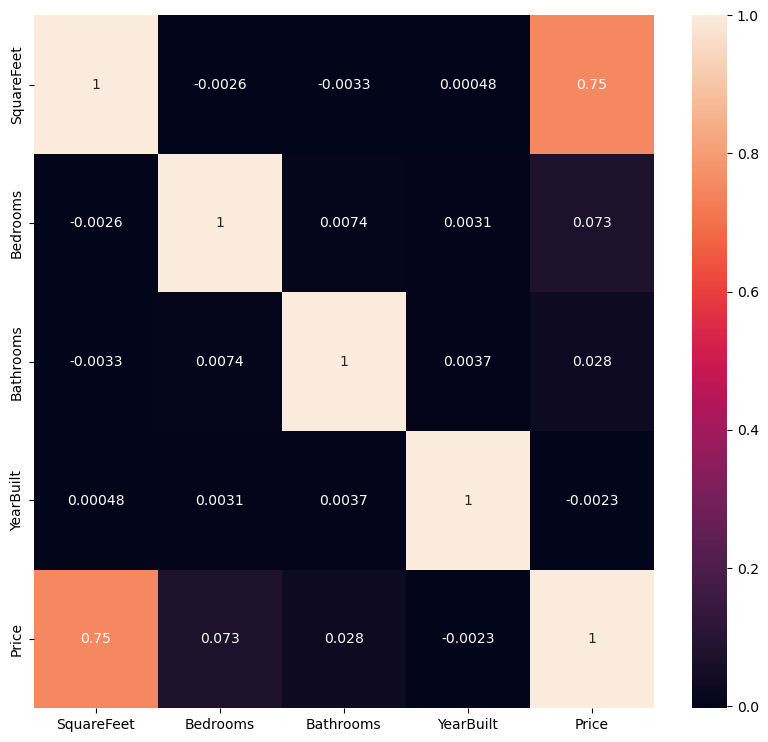

In [90]:
fig, ax= plt.subplots(figsize = (10,9))
sns.heatmap(df.corr(numeric_only=True),annot=True)
fig.show()

<h1>Создание Pipeline модели для регрессии</h1>

In [91]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
df.dtypes

SquareFeet        int64
Bedrooms          int64
Bathrooms         int64
Neighborhood     object
YearBuilt         int64
Price           float64
dtype: object

<h3>Pipelines для заполнение отсутствующих данных (SimpleImputer), ран;ирование имеющихся данных в некоторых пределах (MinMaxScaler) и декодирования категориальных признаков (OneHotencoder)</h3>
<h5>SimpleImputer(strategy='mean') заменяет отсутствующие данные их средним значением по столбцу</h5>
<h5>Для MinMaxScaler:</h5>
<h5>X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))</h5>
<h5>X_scaled = X_std * (max - min) + min - итоговое значение для данных из num_col</h5>

In [92]:
num_col = ['SquareFeet','Bedrooms','Bathrooms']
num_pipe = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

cat_col = ['Neighborhood']
cat_pipe = Pipeline(steps = [
    ('encoder', OneHotEncoder())
])

transform = ColumnTransformer([
    ('num_transform',num_pipe, num_col),
    ('cat_transform', cat_pipe, cat_col)
], remainder = 'drop')

<h3>Разделение на train/test</h3>

In [93]:
from sklearn.model_selection import train_test_split
X = df.drop(['YearBuilt','Price'], axis =1)
y = df.Price
print(X.iloc[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

SquareFeet       2126
Bedrooms            4
Bathrooms           1
Neighborhood    Rural
Name: 0, dtype: object


<h3>Список моделей для оценки их качества решения</h3>

In [94]:
import sklearn.metrics as sm

from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RANSACRegressor, ElasticNet, SGDRegressor, BayesianRidge, LinearRegression, Lasso, Ridge

regressors = [
    LinearRegression(),
    PLSRegression(),
    Lasso(),
    Ridge(),
    BayesianRidge(),
    SGDRegressor(),
    RANSACRegressor(),
    ElasticNet(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    DecisionTreeRegressor()
]


<h1>Выбор модели для решения задачи</h1>

<h2>Данные на основе кросс-валидации</h2>

In [95]:
# validate
from sklearn.model_selection import cross_val_score

for regressor in regressors:
    model_pipe = Pipeline([
        ('transform', transform),
        ('clf',regressor)
    ])
    print(f"{regressor} cross_val_score {cross_val_score(model_pipe, X, y)}")

LinearRegression() cross_val_score [0.55855366 0.57388569 0.57551909 0.57002188 0.57252351]
PLSRegression() cross_val_score [0.55859485 0.57393801 0.57549798 0.57006519 0.57251226]
Lasso() cross_val_score [0.55859828 0.57394606 0.57549107 0.57003774 0.57251149]
Ridge() cross_val_score [0.55860162 0.57394491 0.57549134 0.57003576 0.57251085]
BayesianRidge() cross_val_score [0.55859916 0.57394617 0.57549111 0.57003608 0.57251211]
SGDRegressor() cross_val_score [0.55851654 0.57382537 0.57500934 0.56999906 0.57212965]
RANSACRegressor() cross_val_score [0.52944742 0.53288662 0.56751362 0.54859534 0.55470171]
ElasticNet() cross_val_score [0.14980155 0.15208297 0.15280514 0.1513372  0.151229  ]
RandomForestRegressor() cross_val_score [0.44087682 0.44806951 0.4485002  0.44717303 0.44943103]
GradientBoostingRegressor() cross_val_score [0.55796233 0.57211574 0.57425018 0.56906597 0.5714523 ]
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsampl

<h2>Проверка моделей на различных метриках</h2>

In [96]:
# choose pipeline
for regressor in regressors:
    model_pipe = Pipeline([
        ('transform', transform),
        ('clf',regressor)
    ])
    model_pipe.fit(X_train, y_train)
    y_pred = model_pipe.predict(X_test)
    print(f"Regressor {regressor} model performance:")
    print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(y_test, y_pred), 2))
    print("Mean squared error(MSE) =", round(sm.mean_squared_error(y_test, y_pred), 2))
    print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2))
    print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
    print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
    print(f'test score = {round(model_pipe.score(X_test,y_test)*100,2)}%')
    print()

Regressor LinearRegression() model performance:
Mean absolute error(MAE) = 39738.66
Mean squared error(MSE) = 2468187499.13
Median absolute error = 33899.5
Explain variance score = 0.57
R2 score = 0.57
test score = 57.29%

Regressor PLSRegression() model performance:
Mean absolute error(MAE) = 39737.07
Mean squared error(MSE) = 2467929137.93
Median absolute error = 33861.79
Explain variance score = 0.57
R2 score = 0.57
test score = 57.3%

Regressor Lasso() model performance:
Mean absolute error(MAE) = 39738.11
Mean squared error(MSE) = 2468014199.19
Median absolute error = 33842.38
Explain variance score = 0.57
R2 score = 0.57
test score = 57.3%

Regressor Ridge() model performance:
Mean absolute error(MAE) = 39738.0
Mean squared error(MSE) = 2468011769.78
Median absolute error = 33835.42
Explain variance score = 0.57
R2 score = 0.57
test score = 57.3%

Regressor BayesianRidge() model performance:
Mean absolute error(MAE) = 39738.14
Mean squared error(MSE) = 2468017830.86
Median absolu

<h3>В результате экспериментальных данных выбор пал на BayessianRigde регрессор</h3>
<h3>Как можно увидеть из полученных выше данных, у некоторых моделей есть схожие по значениям с BayessianRigde метрики, поэтому для данной задачи подходит не только он. Ниже метрики только для BayessianRidge</h3>

In [97]:
model_pipe_main = Pipeline([
    ('transform', transform),
    ('clf', BayesianRidge())
])
model_pipe_main.fit(X_train, y_train)
y_pred = model_pipe_main.predict(X_test)
print("BayesianRidge model performance:")
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(y_test, y_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(y_test, y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
print(f'test score = {round(model_pipe_main.score(X_test,y_test)*100,2)}%')
print()

BayesianRidge model performance:
Mean absolute error(MAE) = 39738.14
Mean squared error(MSE) = 2468017830.86
Median absolute error = 33841.65
Explain variance score = 0.57
R2 score = 0.57
test score = 57.3%



<h3>Вид данных для тестирования</р3>

In [98]:
test_data = pd.merge(pd.DataFrame(X_test), pd.DataFrame(y_test), right_index=True, left_index=True)
test_data.join(pd.DataFrame(y_pred))[:5]

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,Price,0
33553,1894,5,1,Rural,170835.035713,NaN
9427,1001,5,3,Suburb,126913.469998,303079.925512
199,2264,4,3,Suburb,246611.883092,198059.460693
12447,2299,5,1,Suburb,244250.462969,140666.309529
39489,2651,2,1,Suburb,271127.650112,NaN


In [99]:
df.iloc[15109].to_frame()

,15109
SquareFeet,2160
Bedrooms,2
Bathrooms,3
Neighborhood,Rural
YearBuilt,2015
Price,225938.368593


In [100]:
print(f"test labels shape: {y_test.shape}\npredicted labels shape: {y_pred.shape}")
print(f"Model parameters list: {model_pipe_main.get_params().keys()}")

test labels shape: (15000,)
predicted labels shape: (15000,)
Model parameters list: dict_keys(['memory', 'steps', 'verbose', 'transform', 'clf', 'transform__n_jobs', 'transform__remainder', 'transform__sparse_threshold', 'transform__transformer_weights', 'transform__transformers', 'transform__verbose', 'transform__verbose_feature_names_out', 'transform__num_transform', 'transform__cat_transform', 'transform__num_transform__memory', 'transform__num_transform__steps', 'transform__num_transform__verbose', 'transform__num_transform__imputer', 'transform__num_transform__scale', 'transform__num_transform__imputer__add_indicator', 'transform__num_transform__imputer__copy', 'transform__num_transform__imputer__fill_value', 'transform__num_transform__imputer__keep_empty_features', 'transform__num_transform__imputer__missing_values', 'transform__num_transform__imputer__strategy', 'transform__num_transform__scale__clip', 'transform__num_transform__scale__copy', 'transform__num_transform__scale__fe

<h2>Обучение Pipeline при помощи рандомизированного поиска гиперпараметров модели с использованием в качестве метрики качества кросс-валидацию</h2>

In [101]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param = {
       }

grid = RandomizedSearchCV(estimator = model_pipe_main,
                          param_distributions = param,
                          n_iter = 5,
                          cv=5,
                          verbose = 2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


/home/alexey/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .................................................... total time=   0.1s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transform',
                                              ColumnTransformer(transformers=[('num_transform',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                MinMaxScaler())]),
                                                                               ['SquareFeet',
                                                                                'Bedrooms',
                                                                                'Bathrooms']),
                                                                              ('cat_transform',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['Neighborhood'])])),
                                             ('clf', BayesianRidge())]),
                   n_iter=5, param_distributions={}, verbose=2)

<h1>Результирующее значение метрик для обученного PipeLine</h1>

In [102]:
y_pred = grid.predict(X_test)
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(y_test, y_pred), 2))
print("Mean squared error(MSE) =", round(sm.mean_squared_error(y_test, y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))
print(f'test score = {round(model_pipe_main.score(X_test,y_test)*100,2)}%')

Mean absolute error(MAE) = 39738.14
Mean squared error(MSE) = 2468017830.86
Median absolute error = 33841.65
Explain variance score = 0.57
R2 score = 0.57
test score = 57.3%
